In [0]:
import logging

logger = spark._jvm.org.apache.log4j
logging.getLogger("py4j.java_gateway").setLevel(logging.ERROR)

In [0]:
%sh conda update -n base -c defaults conda

/bin/bash: conda: command not found

In [0]:
%sh pip uninstall fbprophet pystan

WARNING: Skipping fbprophet as it is not installed.
Found existing installation: pystan 2.19.1.1
Uninstalling pystan-2.19.1.1:
 Would remove:
 /databricks/python3/lib/python3.8/site-packages/pystan-2.19.1.1.dist-info/*
 /databricks/python3/lib/python3.8/site-packages/pystan/*
ERROR: Exception:
Traceback (most recent call last):
 File "/databricks/python3/lib/python3.8/site-packages/pip/_internal/cli/base_command.py", line 189, in _main
 status = self.run(options, args)
 File "/databricks/python3/lib/python3.8/site-packages/pip/_internal/commands/uninstall.py", line 87, in run
 uninstall_pathset = req.uninstall(
 File "/databricks/python3/lib/python3.8/site-packages/pip/_internal/req/req_install.py", line 658, in uninstall
 uninstalled_pathset.remove(auto_confirm, verbose)
 File "/databricks/python3/lib/python3.8/site-packages/pip/_internal/req/req_uninstall.py", line 394, in remove
 if auto_confirm or self._allowed_to_proceed(verbose):
 File "/databricks/python3/lib/python3.8/site-packages/pip/_internal/req/req_uninstall.py", line 437, in _allowed_to_proceed
 return ask('Proceed (y/n)? ', ('y', 'n')) == 'y'
 File "/databricks/python3/lib/python3.8/site-packages/pip/_internal/utils/misc.py", line 221, in ask
 _check_no_input(message)
 File "/databricks/python3/lib/python3.8/site-packages/pip/_internal/utils/misc.py", line 211, in _check_no_input
 raise Exception(
Exception: No input was expected ($PIP_NO_INPUT set); question: Proceed (y/n)?

In [0]:
%sh pip install pystan==2.19.1.1

Requirement already satisfied: pystan==2.19.1.1 in /databricks/python3/lib/python3.8/site-packages (2.19.1.1)
Requirement already satisfied: numpy>=1.7 in /databricks/python3/lib/python3.8/site-packages (from pystan==2.19.1.1) (1.19.2)
Requirement already satisfied: Cython!=0.25.1,>=0.22 in /databricks/python3/lib/python3.8/site-packages (from pystan==2.19.1.1) (0.29.23)
WARNING: You are using pip version 21.0.1; however, version 21.3.1 is available.
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.

In [0]:
%sh conda install -c conda-forge fbprophet

/bin/bash: conda: command not found

In [0]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
from sklearn.metrics import mean_absolute_error
import itertools
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook


In [0]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics


## Load data

In [0]:
path = "/dbfs/FileStore/datasets/eco2mix_conso_bretagne.csv"

df = pd.read_csv(path, delimiter=";")
df['DateHeure'] = pd.to_datetime(df['DateHeure'], format='%Y-%m-%d %H:%M:%S.%f')

print(df.head())
print(df.shape)
print(df.dtypes)

Region DateHeure Consommation
0 Bretagne 2013-01-01 17:00:00 2404.0
1 Bretagne 2013-04-26 22:00:00 2404.0
2 Bretagne 2013-05-16 02:30:00 2404.0
3 Bretagne 2013-07-15 15:30:00 2404.0
4 Bretagne 2013-09-19 18:30:00 2404.0
(148944, 3)
Region object
DateHeure datetime64[ns]
Consommation float64
dtype: object

In [0]:
display(df)

Region DateHeure Consommation Bretagne 2013-01-01T17:00:00.000+0000 2404.0 Bretagne 2013-04-26T22:00:00.000+0000 2404.0 Bretagne 2013-05-16T02:30:00.000+0000 2404.0 Bretagne 2013-07-15T15:30:00.000+0000 2404.0 Bretagne 2013-09-19T18:30:00.000+0000 2404.0 Bretagne 2013-09-19T20:00:00.000+0000 2404.0 Bretagne 2013-10-10T19:00:00.000+0000 2404.0 Bretagne 2014-03-16T01:30:00.000+0000 2404.0 Bretagne 2014-04-09T05:30:00.000+0000 2404.0 Bretagne 2014-04-25T16:30:00.000+0000 2404.0 Bretagne 2014-05-13T19:00:00.000+0000 2404.0 Bretagne 2014-06-18T10:30:00.000+0000 2404.0 Bretagne 2014-06-20T15:00:00.000+0000 2404.0 Bretagne 2014-06-24T13:00:00.000+0000 2404.0 Bretagne 2014-06-27T14:00:00.000+0000 2404.0 Bretagne 2014-07-07T11:30:00.000+0000 2404.0 Bretagne 2014-07-09T23:00:00.000+0000 2404.0 Bretagne 2014-08-19T14:30:00.000+0000 2404.0 Bretagne 2014-10-03T14:00:00.000+0000 2404.0 Bretagne 2014-11-02T00:00:00.000+0000 2404.0 Bretagne 2015-03-28T06:30:00.000+0000 2404.0 Bretagne 2015-04-08T20:00:00.000+0000 2404.0 Bretagne 2015-04-16T09:30:00.000+0000 2404.0 Bretagne 2015-04-29T21:30:00.000+0000 2404.0 Bretagne 2015-05-11T23:00:00.000+0000 2404.0 Bretagne 2015-05-29T09:00:00.000+0000 2404.0 Bretagne 2015-09-01T10:30:00.000+0000 2404.0 Bretagne 2015-09-01T14:00:00.000+0000 2404.0 Bretagne 2015-09-14T13:30:00.000+0000 2404.0 Bretagne 2015-10-14T16:30:00.000+0000 2404.0 Bretagne 2015-12-14T05:30:00.000+0000 2404.0 Bretagne 2016-01-01T08:30:00.000+0000 2404.0 Bretagne 2016-01-10T06:00:00.000+0000 2404.0 Bretagne 2016-03-26T03:00:00.000+0000 2404.0 Bretagne 2016-03-27T04:30:00.000+0000 2404.0 Bretagne 2016-04-24T02:30:00.000+0000 2404.0 Bretagne 2016-05-31T13:30:00.000+0000 2404.0 Bretagne 2016-06-07T23:00:00.000+0000 2404.0 Bretagne 2016-07-01T14:00:00.000+0000 2404.0 Bretagne 2016-07-13T23:00:00.000+0000 2404.0 Bretagne 2016-07-27T14:00:00.000+0000 2404.0 Bretagne 2016-08-10T00:00:00.000+0000 2404.0 Bretagne 2016-08-24T23:00:00.000+0000 2404.0 Bretagne 2016-09-22T08:30:00.000+0000 2404.0 Bretagne 2016-09-23T09:00:00.000+0000 2404.0 Bretagne 2016-11-12T17:00:00.000+0000 2404.0 Bretagne 2016-11-12T21:00:00.000+0000 2404.0 Bretagne 2016-12-24T05:30:00.000+0000 2404.0 Bretagne 2017-03-27T19:00:00.000+0000 2404.0 Bretagne 2017-03-28T06:30:00.000+0000 2404.0 Bretagne 2017-06-13T13:30:00.000+0000 2404.0 Bretagne 2017-06-15T14:00:00.000+0000 2404.0 Bretagne 2017-08-29T23:00:00.000+0000 2404.0 Bretagne 2017-09-25T19:30:00.000+0000 2404.0 Bretagne 2017-10-04T19:30:00.000+0000 2404.0 Bretagne 2018-03-25T07:00:00.000+0000 2404.0 Bretagne 2018-05-02T21:30:00.000+0000 2404.0 Bretagne 2018-06-23T00:00:00.000+0000 2404.0 Bretagne 2018-06-26T23:00:00.000+0000 2404.0 Bretagne 2018-08-20T14:00:00.000+0000 2404.0 Bretagne 2018-08-22T10:30:00.000+0000 2404.0 Bretagne 2018-08-29T09:30:00.000+0000 2404.0 Bretagne 2018-09-03T13:30:00.000+0000 2404.0 Bretagne 2018-09-10T13:30:00.000+0000 2404.0 Bretagne 2018-09-17T09:30:00.000+0000 2404.0 Bretagne 2019-04-10T05:30:00.000+0000 2404.0 Bretagne 2019-05-04T14:00:00.000+0000 2404.0 Bretagne 2019-05-04T22:30:00.000+0000 2404.0 Bretagne 2019-06-11T18:30:00.000+0000 2404.0 Bretagne 2019-06-20T15:00:00.000+0000 2404.0 Bretagne 2019-06-21T14:30:00.000+0000 2404.0 Bretagne 2019-07-23T16:30:00.000+0000 2404.0 Bretagne 2019-08-08T13:30:00.000+0000 2404.0 Bretagne 2019-08-26T10:30:00.000+0000 2404.0 Bretagne 2019-10-07T21:00:00.000+0000 2404.0 Bretagne 2019-10-15T15:30:00.000+0000 2404.0 Bretagne 2019-11-11T04:30:00.000+0000 2404.0 Bretagne 2020-02-09T05:00:00.000+0000 2404.0 Bretagne 2020-04-06T23:30:00.000+0000 2404.0 Bretagne 2020-06-08T13:30:00.000+0000 2404.0 Bretagne 2020-06-25T23:00:00.000+0000 2404.0 Bretagne 2020-11-15T22:00:00.000+0000 2404.0 Bretagne 2021-02-22T05:00:00.000+0000 2404.0 Bretagne 2021-04-04T22:30:00.000+0000 2404.0 Bretagne 2021-04-29T16:00:00.000+0000 2404.0 Bretagne 2021-05-01T13:00:00.000+0000 2404.0 Bretagne 2021-05-03T21:30:00.000+0000 2404.0 Bretagne 2021-05-14T22:00:00.000+0000 2404.0 Bretagne 2

In [0]:
df_hourly = df[['DateHeure', 'Consommation']]
df_hourly.columns = ['ds','y']

In [0]:
# remove region, group by day
df['Date'] = df['DateHeure'].dt.date
df_day = df[['Date','Consommation']].groupby(by='Date', dropna=False).sum().reset_index()
df_day.columns = ['ds','y']

print(df_day.head())
print(df_day.shape)
print(df_day.columns)

ds y
0 2013-01-01 121979.0
1 2013-01-02 153379.0
2 2013-01-03 151563.0
3 2013-01-04 150836.0
4 2013-01-05 137267.0
(3103, 2)
Index(['ds', 'y'], dtype='object')

In [0]:
df_day['ds'] = pd.to_datetime(df_day['ds'])

In [0]:
df_day['year'] = pd.DatetimeIndex(df_day['ds']).year

In [0]:
datemin = df_day['ds'].min()
datemax = df_day['ds'].max()
print(f"Dataset is starting on {datemin}")
print(f"Dataset is ending on {datemax}")

Dataset is starting on 2013-01-01 00:00:00
Dataset is ending on 2021-06-30 00:00:00

In [0]:
df_day['year'].value_counts()

Out[9]: 2016 366
2020 366
2014 365
2018 365
2013 365
2015 365
2017 365
2019 365
2021 181
Name: year, dtype: int64

<command-1058371876938326>:2: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data. If it was intended as data, set the format string to an empty string to suppress this warning. If it was intended as a format string, explicitly pass the x-values as well. Alternatively, rename the entry in 'data'.
 ax.plot('ds', 'y', data=df_day)

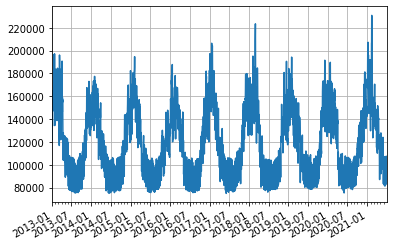

In [0]:
fig, ax = plt.subplots()
ax.plot('ds', 'y', data=df_day)

# Major ticks every 6 months.
fmt_half_year = mdates.MonthLocator(interval=6)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Round to nearest years.
# datemin = np.datetime64(df_day['ds'][0], 'Y')
# datemax = np.datetime64(df_day['ds'][-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# Format the coords message box, i.e. the numbers displayed as the cursor moves
# across the axes within the interactive GUI.
ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.format_ydata = lambda x: f'${x:.2f}'  # Format the price.
ax.grid(True)

# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()

plt.show()


## Cleaning

In [0]:
REMOVE_LEAP = False

In [0]:
# REMOVE 29 février
#for i in range(2013, 2021, 1):
#  DateTimeSeries.dt.is_leap_year
if REMOVE_LEAP:
  print(df_day.shape)
  df_day = df_day.loc[~(df_day['ds'].dt.month.eq(2) & df_day['ds'].dt.day.eq(29))] 
  print(df_day.shape)

In [0]:
df_day['year'].value_counts()

Out[12]: 2016 366
2020 366
2014 365
2018 365
2013 365
2015 365
2017 365
2019 365
2021 181
Name: year, dtype: int64

## Train model

In [0]:
m = Prophet(daily_seasonality=False)
m.add_country_holidays(country_name='FR')
m.fit(df_day)

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
Out[13]: INFO:py4j.java_gateway:Received command c on object id p0
<prophet.forecaster.Prophet at 0x7ff191dae370>INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

In [0]:
future = m.make_future_dataframe(periods=365)
future.tail()

Out[14]:

ds 
 
 
 
 
 3463 
 2022-06-26 
 
 
 3464 
 2022-06-27 
 
 
 3465 
 2022-06-28 
 
 
 3466 
 2022-06-29 
 
 
 3467 
 2022-06-30

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

In [0]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p

ds 
 yhat 
 yhat_lower 
 yhat_upper 
 
 
 
 
 3463 
 2022-06-26 
 85133.863185 
 71882.332249 
 98406.603606 
 
 
 3464 
 2022-06-27 
 105491.644008 
 92459.909642 
 119173.800742 
 
 
 3465 
 2022-06-28 
 108972.972274 
 94670.674293 
 123343.676317 
 
 
 3466 
 2022-06-29 
 109371.268699 
 96321.369106 
 122772.446174 
 
 
 3467 
 2022-06-30 
 109666.816903 
 95965.597303 
 122628.075878

INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0

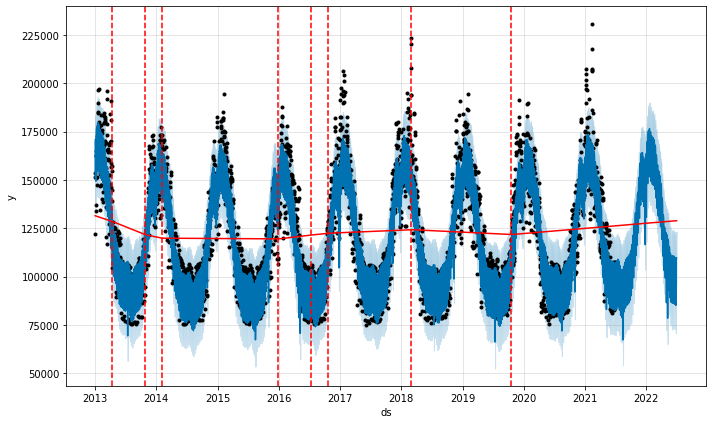

In [0]:
from prophet.plot import add_changepoints_to_plot

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

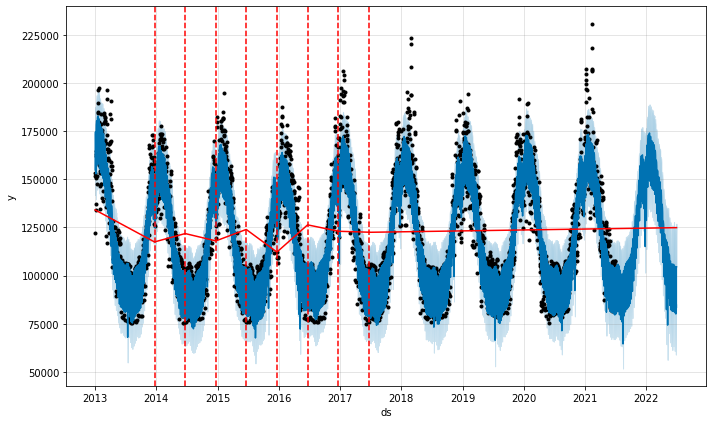

In [0]:
m = Prophet(daily_seasonality=False, 
            changepoints=['2013-12-21', '2014-06-21', '2014-12-21', '2015-06-21', '2015-12-21', '2016-06-21', '2016-12-21', '2017-06-21'], 
            changepoint_prior_scale=1)
#m = Prophet(daily_seasonality=False, changepoint_prior_scale=0.01)
m.add_country_holidays(country_name='FR')
m.fit(df_day)

future = m.make_future_dataframe(periods=365)
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

from prophet.plot import add_changepoints_to_plot

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [0]:
train_test_limit = datetime(2019, 1, 1)

In [0]:
df_train = df_day[df_day['ds'] < train_test_limit]
print(df_train.shape)

m = Prophet(daily_seasonality=False)
m.add_country_holidays(country_name='FR')
m.fit(df_train)

(2191, 3)
Out[27]: <prophet.forecaster.Prophet at 0x7ff3e9ab9ca0>

## Cross validation

Prophet has a built in .cross_validation() function which takes in:
- a model (m)
- the length of time each forecast should cover (horizon)
- how frequently to make forecasts (period)
- the amount of data to train on before making any predictions (initial)

This cross validation procedure can be done automatically for a range of historical cutoffs using the cross_validation function. We specify the forecast horizon (horizon), and then optionally the size of the initial training period (initial) and the spacing between cutoff dates (period). By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.

In [0]:
from prophet.diagnostics import cross_validation

#df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
#parallel='processes'

df_cv = cross_validation(m, initial='730 days', period='365 days', horizon='365 days')
df_p = performance_metrics(df_cv, rolling_window=1)

INFO:prophet:Making 4 forecasts with cutoffs between 2015-01-01 00:00:00 and 2017-12-31 00:00:00
 0%| | 0/4 [00:00<?, ?it/s]

In [0]:
from prophet.diagnostics import cross_validation

#df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
#parallel='processes'

df_cv = cross_validation(m, initial='730 days', period='365 days', horizon='365 days', parallel='processes')
df_p = performance_metrics(df_cv, rolling_window=1)

INFO:prophet:Making 4 forecasts with cutoffs between 2015-01-01 00:00:00 and 2017-12-31 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff3ec1d26a0>

In [0]:
df_cv['cutoff'].value_counts()

Out[30]: 2016-01-01 365
2017-12-31 365
2015-01-01 365
2016-12-31 365
Name: cutoff, dtype: int64

In [0]:
df_p

Out[31]:

horizon 
 mse 
 rmse 
 mae 
 mape 
 mdape 
 smape 
 coverage 
 
 
 
 
 0 
 365 days 
 2.506509e+08 
 15831.95976 
 12535.829098 
 0.10396 
 0.094258 
 0.106031 
 0.494521

In [0]:
HYPERPARAMTER_TUNING = False

In [0]:
if HYPERPARAMTER_TUNING:
  
  param_grid = {  
      'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
      'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
      'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
      'daily_seasonality': [True, False],
      'weekly_seasonality': [True, False],
      'yearly_seasonality': [True, False],
  }

  cutoffs = pd.to_datetime(['2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01'])

  # Generate all combinations of parameters
  all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
  rmses = []
  maes = []

  # Use cross validation to evaluate all parameters
  for params in all_params:
      m = Prophet(**params).fit(df_train)
      #df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', parallel='processes')
      df_cv = cross_validation(m, horizon='365 days')
      df_p = performance_metrics(df_cv, rolling_window=1)
      #idem pour mae A FAIRE
      rmses.append(df_p['rmse'].values[0])
      maes.append(df_p['mae'].values[0])

  # Find the best parameters
  tuning_results = pd.DataFrame(all_params)
  tuning_results['rmse'] = rmses
  tuning_results['mae'] = maes
  print(tuning_results)

  best_params = all_params[np.argmin(maes)]
  print(best_params)

  m = Prophet(**best_params).fit(df_train)

In [0]:
df_test = df_day[(df_day['ds'] >= train_test_limit) & (df_day['ds'] < train_test_limit + timedelta(days = 365))]
print(df_test.shape)

range_test = m.make_future_dataframe(periods=365, freq='d', include_history=False)
fc_test = m.predict(range_test)

(365, 3)

In [0]:
display(fc_test)

ds trend yhat_lower yhat_upper trend_lower trend_upper Armistice 1918 Armistice 1918_lower Armistice 1918_upper Armistice 1945 Armistice 1945_lower Armistice 1945_upper Ascension Ascension_lower Ascension_upper Assomption Assomption_lower Assomption_upper Fête du Travail Fête du Travail_lower Fête du Travail_upper Fête nationale Fête nationale_lower Fête nationale_upper Jour de l'an Jour de l'an_lower Jour de l'an_upper Lundi de Pentecôte Lundi de Pentecôte_lower Lundi de Pentecôte_upper Lundi de Pâques Lundi de Pâques_lower Lundi de Pâques_upper Noël Noël_lower Noël_upper Toussaint Toussaint_lower Toussaint_upper additive_terms additive_terms_lower additive_terms_upper holidays holidays_lower holidays_upper weekly weekly_lower weekly_upper yearly yearly_lower yearly_upper multiplicative_terms multiplicative_terms_lower multiplicative_terms_upper yhat 2019-01-01T00:00:00.000+0000 124686.9710973223 131912.7056416217 155652.90356708353 124686.9710973223 124686.9710973223 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -14916.854077253136 -14916.854077253136 -14916.854077253136 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 18753.337904133496 18753.337904133496 18753.337904133496 -14916.854077253136 -14916.854077253136 -14916.854077253136 6343.343665703932 6343.343665703932 6343.343665703932 27326.8483156827 27326.8483156827 27326.8483156827 0.0 0.0 0.0 143440.30900145578 2019-01-02T00:00:00.000+0000 124689.67056501805 147565.95364895702 171547.04578523902 124689.67056501805 124689.67056501805 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 35121.857107212774 35121.857107212774 35121.857107212774 0.0 0.0 0.0 6858.793164898834 6858.793164898834 6858.793164898834 28263.063942313936 28263.063942313936 28263.063942313936 0.0 0.0 0.0 159811.52767223082 2019-01-03T00:00:00.000+0000 124692.37003271384 149389.80123006777 173315.0391791954 124692.37003271384 124692.37003271384 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 36380.90520458779 36380.90520458779 36380.90520458779 0.0 0.0 0.0 7116.507282805588 7116.507282805588 7116.507282805588 29264.397921782205 29264.397921782205 29264.397921782205 0.0 0.0 0.0 161073.27523730163 2019-01-04T00:00:00.000+0000 124695.0695004096 149255.73971672292 173580.71960227072 124695.0695004096 124695.0695004096 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 35946.71789638404 35946.71789638404 35946.71789638404 0.0 0.0 0.0 5631.7326314621405 5631.7326314621405 5631.7326314621405 30314.9852649219 30314.9852649219 30314.9852649219 0.0 0.0 0.0 160641.78739679366 2019-01-05T00:00:00.000+0000 124697.76896810539 133139.73953936002 157275.60586485194 124697.76896810539 124697.76896810539 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 21002.68887572898 21002.68887572898 21002.68887572898 0.0 0.0 0.0 -10395.362831878241 -10395.362831878241 -10395.362831878241 31398.05170760722 31398.05170760722 31398.05170760722 0.0 0.0 0.0 145700.45784383436 2019-01-06T00:00:00.000+0000 124700.46843580117 127016.37604019756 151829.33854283462 124700.46843580117 124700.46843580117 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 14531.278959037707 14531.278959037707 14531.278959037707 0.0 0.0 0.0 -17965.03401988161 -17965.03401988161 -17965.03401988161 32496.312978919315 32496.312978919315 32496.312978919315 0.0 0.0 0.0 139231.7473948389 2019-01-07T00:00:00.000+0000 124703.16790349693 148515.66385174484 172841.67379894055 124703.16790349693 124703.16790349693 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 360

MAE: 6953

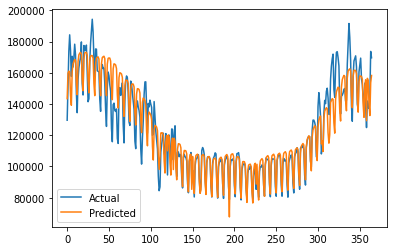

In [0]:
y_true = df_test['y'].values
y_pred = fc_test['yhat'].values
mae = int(round(mean_absolute_error(y_true, y_pred),0))
print(f'MAE: {mae}')

# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

####MAE

sans vacances : 7309

avec vacances FR : 6974

## Visualizations

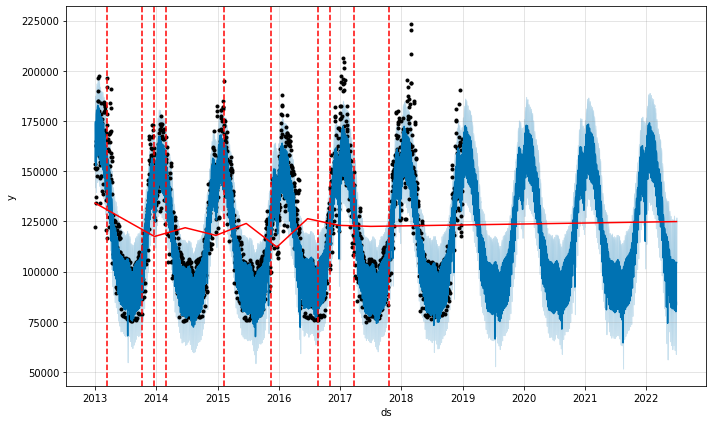

In [0]:
from prophet.plot import add_changepoints_to_plot

fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)

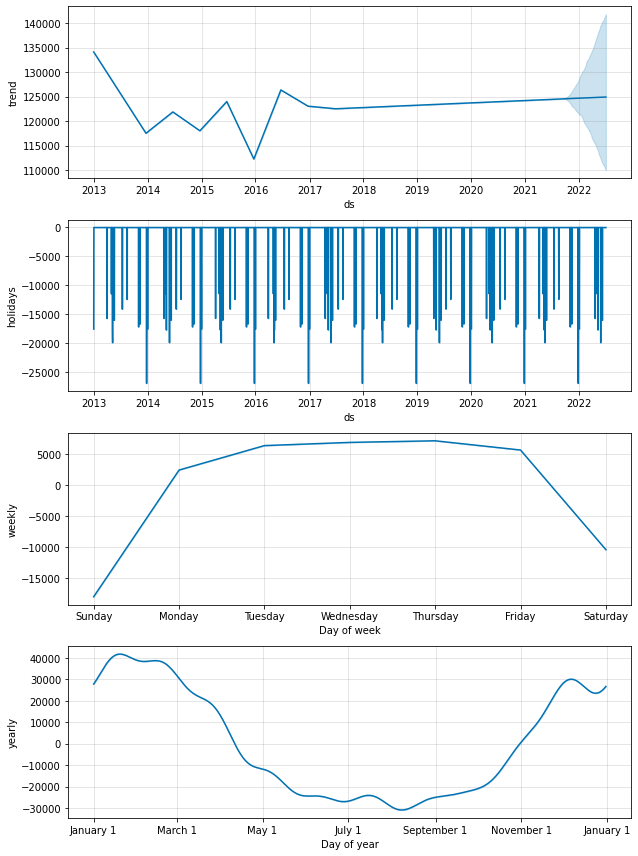

In [0]:
fig2 = m.plot_components(forecast)

In [0]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

Out[49]:

In [0]:
plot_components_plotly(m, forecast)

Out[50]:

## Kats

In [0]:
!pip install --upgrade kats[all]

Collecting kats[all]
 Downloading kats-0.1.0.tar.gz (6.3 MB)
 | 10 kB 27.5 MB/s eta 0:00:01 | | 20 kB 21.0 MB/s eta 0:00:01 |▏ | 30 kB 16.1 MB/s eta 0:00:01 |▏ | 40 kB 14.2 MB/s eta 0:00:01 |▎ | 51 kB 15.8 MB/s eta 0:00:01 |▎ | 61 kB 15.3 MB/s eta 0:00:01 |▍ | 71 kB 15.7 MB/s eta 0:00:01 |▍ | 81 kB 17.5 MB/s eta 0:00:01 |▌ | 92 kB 17.1 MB/s eta 0:00:01 |▌ | 102 kB 18.5 MB/s eta 0:00:01 |▋ | 112 kB 18.5 MB/s eta 0:00:01 |▋ | 122 kB 18.5 MB/s eta 0:00:01 |▊ | 133 kB 18.5 MB/s eta 0:00:01 |▊ | 143 kB 18.5 MB/s eta 0:00:01 |▉ | 153 kB 18.5 MB/s eta 0:00:01 |▉ | 163 kB 18.5 MB/s eta 0:00:01 |▉ | 174 kB 18.5 MB/s eta 0:00:01 |█ | 184 kB 18.5 MB/s eta 0:00:01 |█ | 194 kB 18.5 MB/s eta 0:00:01 |█ | 204 kB 18.5 MB/s eta 0:00:01 |█ | 215 kB 18.5 MB/s eta 0:00:01 |█▏ | 225 kB 18.5 MB/s eta 0:00:01 |█▏ | 235 kB 18.5 MB/s eta 0:00:01 |█▎ | 245 kB 18.5 MB/s eta 0:00:01 |█▎ | 256 kB 18.5 MB/s eta 0:00:01 |█▍ | 266 kB 18.5 MB/s eta 0:00:01 |█▍ | 276 kB 18.5 MB/s eta 0:00:01 |█▌ | 286 kB 18.5 MB/s eta 0:00:01 |█▌ | 296 kB 18.5 MB/s eta 0:00:01 |█▋ | 307 kB 18.5 MB/s eta 0:00:01 |█▋ | 317 kB 18.5 MB/s eta 0:00:01 |█▊ | 327 kB 18.5 MB/s eta 0:00:01 |█▊ | 337 kB 18.5 MB/s eta 0:00:01 |█▊ | 348 kB 18.5 MB/s eta 0:00:01 |█▉ | 358 kB 18.5 MB/s eta 0:00:01 |█▉ | 368 kB 18.5 MB/s eta 0:00:01 |██ | 378 kB 18.5 MB/s eta 0:00:01 |██ | 389 kB 18.5 MB/s eta 0:00:01 |██ | 399 kB 18.5 MB/s eta 0:00:01 |██ | 409 kB 18.5 MB/s eta 0:00:01 |██▏ | 419 kB 18.5 MB/s eta 0:00:01 |██▏ | 430 kB 18.5 MB/s eta 0:00:01 |██▎ | 440 kB 18.5 MB/s eta 0:00:01 |██▎ | 450 kB 18.5 MB/s eta 0:00:01 |██▍ | 460 kB 18.5 MB/s eta 0:00:01 |██▍ | 471 kB 18.5 MB/s eta 0:00:01 |██▌ | 481 kB 18.5 MB/s eta 0:00:01 |██▌ | 491 kB 18.5 MB/s eta 0:00:01 |██▌ | 501 kB 18.5 MB/s eta 0:00:01 |██▋ | 512 kB 18.5 MB/s eta 0:00:01 |██▋ | 522 kB 18.5 MB/s eta 0:00:01 |██▊ | 532 kB 18.5 MB/s eta 0:00:01 |██▊ | 542 kB 18.5 MB/s eta 0:00:01 |██▉ | 552 kB 18.5 MB/s eta 0:00:01 |██▉ | 563 kB 18.5 MB/s eta 0:00:01 |███ | 573 kB 18.5 MB/s eta 0:00:01 |███ | 583 kB 18.5 MB/s eta 0:00:01 |███ | 593 kB 18.5 MB/s eta 0:00:01 |███ | 604 kB 18.5 MB/s eta 0:00:01 |███▏ | 614 kB 18.5 MB/s eta 0:00:01 |███▏ | 624 kB 18.5 MB/s eta 0:00:01 |███▎ | 634 kB 18.5 MB/s eta 0:00:01 |███▎ | 645 kB 18.5 MB/s eta 0:00:01 |███▍ | 655 kB 18.5 MB/s eta 0:00:01 |███▍ | 665 kB 18.5 MB/s eta 0:00:01 |███▍ | 675 kB 18.5 MB/s eta 0:00:01 |███▌ | 686 kB 18.5 MB/s eta 0:00:01 |███▌ | 696 kB 18.5 MB/s eta 0:00:01 |███▋ | 706 kB 18.5 MB/s eta 0:00:01 |███▋ | 716 kB 18.5 MB/s eta 0:00:01 |███▊ | 727 kB 18.5 MB/s eta 0:00:01 |███▊ | 737 kB 18.5 MB/s eta 0:00:01 |███▉ | 747 kB 18.5 MB/s eta 0:00:01 |███▉ | 757 kB 18.5 MB/s eta 0:00:01 |████ | 768 kB 18.5 MB/s eta 0:00:01 |████ | 778 kB 18.5 MB/s eta 0:00:01 |████ | 788 kB 18.5 MB/s eta 0:00:01 |████ | 798 kB 18.5 MB/s eta 0:00:01 |████▏ | 808 kB 18.5 MB/s eta 0:00:01 |████▏ | 819 kB 18.5 MB/s eta 0:00:01 |████▎ | 829 kB 18.5 MB/s eta 0:00:01 |████▎ | 839 kB 18.5 MB/s eta 0:00:01 |████▎ | 849 kB 18.5 MB/s eta 0:00:01 |████▍ | 860 kB 18.5 MB/s eta 0:00:01 |████▍ | 870 kB 18.5 MB/s eta 0:00:01 |████▌ | 880 kB 18.5 MB/s eta 0:00:01 |████▌ | 890 kB 18.5 MB/s eta 0:00:01 |████▋ | 901 kB 18.5 MB/s eta 0:00:01 |████▋ | 911 kB 18.5 MB/s eta 0:00:01 |████▊ | 921 kB 18.5 MB/s eta 0:00:01 |████▊ | 931 kB 18.5 MB/s eta 0:00:01 |████▉ | 942 kB 18.5 MB/s eta 0:00:01 |████▉ | 952 kB 18.5 MB/s eta 0:00:01 |█████ | 962 kB 18.5 MB/s eta 0:00:01 |█████ | 972 kB 18.5 MB/s eta 0:00:01 |█████ | 983 kB 18.5 MB/s eta 0:00:01 |█████ | 993 kB 18.5 MB/s eta 0:00:01 |█████ | 1.0 MB 18.5 MB/s eta 0:00:01 |█████▏ | 1.0 MB 18.5 MB/s eta 0:00:01 |█████▏ | 1.0 MB 18.5 MB/s eta 0:00:01 |█████▎ | 1.0 MB 18.5 MB/s eta 0:00:01 |█████▎ | 1.0 MB 18.5 MB/s eta 0:00:01 |█████▍ | 1.1 MB 18.5 MB/s eta 0:00:01 |█████▍ | 1.1 MB 18.5 MB/s eta 0:00:01 |█████▌ | 1.1 MB 18.5 MB/s eta 0:00:01 |█████▌ | 1.1 MB 18.5 MB/s eta 0:00:01 |████

In [0]:
from kats.consts import TimeSeriesData
from kats.models.prophet import ProphetModel, ProphetParams


In [0]:
df_day.columns = ["time","y","year"]

In [0]:
kats_ts = TimeSeriesData(df_day[["time","y"]])

### Change points

In [0]:
from kats.detectors.cusum_detection import CUSUMDetector

# run detector and find change points
change_points = CUSUMDetector(kats_ts).detector()
change_points

Out[45]: [(TimeSeriesChangePoint(start_time: 2013-04-11 00:00:00, end_time: 2013-04-11 00:00:00, confidence: 1.0),
 <kats.detectors.cusum_detection.CUSUMMetadata at 0x7ff3b2a33ca0>)]

### Outliers

In [0]:
from kats.detectors.outlier import OutlierDetector

ts_outlierDetection = OutlierDetector(kats_ts, 'additive')
ts_outlierDetection.detector()

In [0]:
# from kats.detectors.outlier import MultivariateAnomalyDetector, MultivariateAnomalyDetectorType
# from kats.models.var import VARParams

# import warnings
# warnings.filterwarnings(action='ignore', category=FutureWarning)


# params = VARParams(maxlags=2)
# training_days = 912 #date(2021, 7, 1) - date(2019, 1, 1)

# outliers = MultivariateAnomalyDetector(kats_ts, params, training_days)
# #anomaly_score_df = outliers.detector()
# #outliers.plot()
# #outliers.get_anomaly_timepoints()

### TS features

In [0]:
# Initiate feature extraction class
from kats.tsfeatures.tsfeatures import TsFeatures

features = TsFeatures().transform(kats_ts)
features

INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
/databricks/python/lib/python3.8/site-packages/kats/tsfeatures/tsfeatures.py:391: FutureWarning:

the 'unbiased'' keyword is deprecated, use 'adjusted' instead

INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
/databricks/python/lib/python3.8/site-packages/kats/tsfeatures/tsfeatures.py:402: FutureWarning:

the 'unbiased'' keyword is deprecated, use 'adjusted' instead

/databricks/python/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/databricks/python/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
/databricks/python/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
Out[48]: {'length': 3103,
 'mean': 122553.42732839187,
 'var': 841434913.5969608,
 'entropy': 0.3974353904243942,
 'lumpiness': 1.2709757190432784e+16,
 'stability': 675695093.5617276,
 'flat_spots': 1,
 'hurst': 0.09971712749496514,
 'std1st_der': 8749.786788183632,
 'crossing_points': 199,
 'binarize_mean': 0.43474057363841445,
 'unitroot_kpss': 0.649565748617368,
 'heterogeneity': 2846.417272383972,
 'histogram_mode': 90592.2,
 'linearity': 0.0001424275838226213,
 'trend_strength': 0.9746746652418055,
 'seasonality_strength': 0.8319643021683869,
 'spikiness': 188902088.4567415,
 'peak': 6,
 'trough': 5,
 'level_shift_idx': 2963,
 'level_shift_size': 4472.549999999988,
 'y_acf1': 0.9148580928780208,
 'y_acf5': 3.292694722965873,
 'diff1y_acf1': 0.06585619443112042,
 'diff1y_acf5': 0.27295121792743726,
 'diff2y_acf1': -0.276342557144483,
 'diff2y_acf5': 0.34090107567110217,
 'y_pacf5': 1.0228898738770964,
 'diff1y_pacf5': 0.4454837258526847,
 'diff2y_pacf5': 0.5295193032096048,
 'seas_acf1': 0.8819068155100568,
 'seas_pacf1': 0.17725559462051388,
 'firstmin_ac': 4,
 'firstzero_ac': 86,
 'holt_alpha': 0.995,
 'holt_beta': 0.04738095238095238,
 'hw_alpha': 0.7043777620299485,
 'hw_beta': 1.5058302339686687e-18,
 'hw_gamma': 0.17793128215308668}

## PyCaret

In [0]:
%sh pip install pycaret-ts-alpha

Collecting pycaret-ts-alpha
 Downloading pycaret_ts_alpha-3.0.0.dev1636735356-py3-none-any.whl (479 kB)
Collecting mlxtend>=0.17.0
 Downloading mlxtend-0.19.0-py2.py3-none-any.whl (1.3 MB)
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
Collecting spacy<2.4.0
 Downloading spacy-2.3.7-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.5 MB)
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
Requirement already satisfied: ipywidgets in /databricks/python3/lib/python3.8/site-packages (from pycaret-ts-alpha) (7.6.3)
Requirement already satisfied: pandas in /databricks/python3/lib/python3.8/site-packages (from pycaret-ts-alpha) (1.2.4)
INFO:py4j.java_gateway:Received command c on object id p0
Collecting yellowbrick>=1.0.1
 Downloading yellowbrick-1.3.post1-py3-none-any.whl (271 kB)
Requirement already satisfied: plotly>=5.0.0 in /databricks/python3/lib/python3.8/site-packages (from pycaret-ts-alpha) (5.3.0)
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
Collecting scikit-learn~=0.24.2
 Downloading scikit_learn-0.24.2-cp38-cp38-manylinux2010_x86_64.whl (24.9 MB)
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on object id p0
Collecting tbats>=1.1.0
 Downloading tbats-1.1.0-py3-none-any.whl (43 kB)
INFO:py4j.java_gateway:Received command c on object id p0
Collecting pmdarima>=1.8.0
 Downloading pmdarima-1.8.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.5 MB)
INFO:py4j.java_gateway:Received command c on object id p0
Collecting cufflinks>=0.17.0
 Downloading cufflinks-0.17.3.tar.gz (81 kB)
INFO:py4j.java_gateway:Received command c on object id p0
INFO:py4j.java_gateway:Received command c on o

In [0]:
import pandas as pd
from pycaret.datasets import get_data


data = get_data('pycaret_downloads')
data['Date'] = pd.to_datetime(data['Date'])
data = data.groupby('Date').sum()

Date Total
0 7/8/2021 3773
1 7/9/2021 3172
2 7/10/2021 2079
3 7/11/2021 2725
4 7/12/2021 4542

In [0]:
data = data.asfreq('D') #Convert time series to specified frequency.
data.head()

Out[31]:

Total 
 
 
 Date 
 
 
 
 
 
 2021-07-08 
 3773 
 
 
 2021-07-09 
 3172 
 
 
 2021-07-10 
 2079 
 
 
 2021-07-11 
 2725 
 
 
 2021-07-12 
 4542

In [0]:
display(df_day)

ds y year 2013-01-01T00:00:00.000+0000 121979.0 2013 2013-01-02T00:00:00.000+0000 153379.0 2013 2013-01-03T00:00:00.000+0000 151563.0 2013 2013-01-04T00:00:00.000+0000 150836.0 2013 2013-01-05T00:00:00.000+0000 137267.0 2013 2013-01-06T00:00:00.000+0000 134135.0 2013 2013-01-07T00:00:00.000+0000 163112.0 2013 2013-01-08T00:00:00.000+0000 164850.0 2013 2013-01-09T00:00:00.000+0000 162355.0 2013 2013-01-10T00:00:00.000+0000 158944.0 2013 2013-01-11T00:00:00.000+0000 162372.0 2013 2013-01-12T00:00:00.000+0000 147365.0 2013 2013-01-13T00:00:00.000+0000 151692.0 2013 2013-01-14T00:00:00.000+0000 170873.0 2013 2013-01-15T00:00:00.000+0000 172745.0 2013 2013-01-16T00:00:00.000+0000 177814.0 2013 2013-01-17T00:00:00.000+0000 189766.0 2013 2013-01-18T00:00:00.000+0000 196398.0 2013 2013-01-19T00:00:00.000+0000 184896.0 2013 2013-01-20T00:00:00.000+0000 170956.0 2013 2013-01-21T00:00:00.000+0000 184705.0 2013 2013-01-22T00:00:00.000+0000 179773.0 2013 2013-01-23T00:00:00.000+0000 178327.0 2013 2013-01-24T00:00:00.000+0000 177597.0 2013 2013-01-25T00:00:00.000+0000 197199.0 2013 2013-01-26T00:00:00.000+0000 157522.0 2013 2013-01-27T00:00:00.000+0000 134404.0 2013 2013-01-28T00:00:00.000+0000 165054.0 2013 2013-01-29T00:00:00.000+0000 157911.0 2013 2013-01-30T00:00:00.000+0000 146795.0 2013 2013-01-31T00:00:00.000+0000 153155.0 2013 2013-02-01T00:00:00.000+0000 154487.0 2013 2013-02-02T00:00:00.000+0000 147360.0 2013 2013-02-03T00:00:00.000+0000 147639.0 2013 2013-02-04T00:00:00.000+0000 155084.0 2013 2013-02-05T00:00:00.000+0000 170445.0 2013 2013-02-06T00:00:00.000+0000 178515.0 2013 2013-02-07T00:00:00.000+0000 183803.0 2013 2013-02-08T00:00:00.000+0000 175743.0 2013 2013-02-09T00:00:00.000+0000 156826.0 2013 2013-02-10T00:00:00.000+0000 140296.0 2013 2013-02-11T00:00:00.000+0000 157818.0 2013 2013-02-12T00:00:00.000+0000 174194.0 2013 2013-02-13T00:00:00.000+0000 169790.0 2013 2013-02-14T00:00:00.000+0000 152929.0 2013 2013-02-15T00:00:00.000+0000 160141.0 2013 2013-02-16T00:00:00.000+0000 143741.0 2013 2013-02-17T00:00:00.000+0000 138769.0 2013 2013-02-18T00:00:00.000+0000 156636.0 2013 2013-02-19T00:00:00.000+0000 166978.0 2013 2013-02-20T00:00:00.000+0000 167987.0 2013 2013-02-21T00:00:00.000+0000 179516.0 2013 2013-02-22T00:00:00.000+0000 184619.0 2013 2013-02-23T00:00:00.000+0000 183341.0 2013 2013-02-24T00:00:00.000+0000 169817.0 2013 2013-02-25T00:00:00.000+0000 179459.0 2013 2013-02-26T00:00:00.000+0000 180047.0 2013 2013-02-27T00:00:00.000+0000 181732.0 2013 2013-02-28T00:00:00.000+0000 180500.0 2013 2013-03-01T00:00:00.000+0000 182373.0 2013 2013-03-02T00:00:00.000+0000 170259.0 2013 2013-03-03T00:00:00.000+0000 161144.0 2013 2013-03-04T00:00:00.000+0000 169040.0 2013 2013-03-05T00:00:00.000+0000 156107.0 2013 2013-03-06T00:00:00.000+0000 143799.0 2013 2013-03-07T00:00:00.000+0000 140153.0 2013 2013-03-08T00:00:00.000+0000 135827.0 2013 2013-03-09T00:00:00.000+0000 120642.0 2013 2013-03-10T00:00:00.000+0000 116975.0 2013 2013-03-11T00:00:00.000+0000 165653.0 2013 2013-03-12T00:00:00.000+0000 196159.0 2013 2013-03-13T00:00:00.000+0000 191689.0 2013 2013-03-14T00:00:00.000+0000 173228.0 2013 2013-03-15T00:00:00.000+0000 178707.0 2013 2013-03-16T00:00:00.000+0000 149642.0 2013 2013-03-17T00:00:00.000+0000 136666.0 2013 2013-03-18T00:00:00.000+0000 160307.0 2013 2013-03-19T00:00:00.000+0000 165828.0 2013 2013-03-20T00:00:00.000+0000 160948.0 2013 2013-03-21T00:00:00.000+0000 164390.0 2013 2013-03-22T00:00:00.000+0000 152772.0 2013 2013-03-23T00:00:00.000+0000 127256.0 2013 2013-03-24T00:00:00.000+0000 122006.0 2013 2013-03-25T00:00:00.000+0000 160205.0 2013 2013-03-26T00:00:00.000+0000 168268.0 2013 2013-03-27T00:00:00.000+0000 168375.0 2013 2013-03-28T00:00:00.000+0000 169394.0 2013 2013-03-29T00:00:00.000+0000 184056.0 2013 2013-03-30T00:00:00.000+0000 168987.0 2013 2013-03-31T00:00:00.000+0000 152653.0 2013 2013-04-01T00:00:00.000+0000 148033.0 2013 2013-04-02T00:00:00.000+0000 164616.0 2013 2013-04-03T00:00:00.000+0000 17003

In [0]:
df_day_pycaret = df_day[['ds','y']]
df_day_pycaret['Date'] = pd.to_datetime(df_day_pycaret['ds'])
df_day_pycaret = df_day_pycaret.groupby('Date').sum()
df_day_pycaret = df_day_pycaret.asfreq('D')
df_day_pycaret.head()

Out[33]:

y 
 
 
 Date 
 
 
 
 
 
 2013-01-01 
 121979.0 
 
 
 2013-01-02 
 153379.0 
 
 
 2013-01-03 
 151563.0 
 
 
 2013-01-04 
 150836.0 
 
 
 2013-01-05 
 137267.0

In [0]:
data = df_day_pycaret

Out[35]:

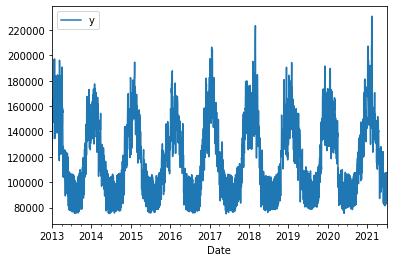

<AxesSubplot:xlabel='Date'>

In [0]:
# plot the data
data.plot()

In [0]:
# with functional API
from pycaret.time_series import *

setup(data, fh = 7, fold = 3, session_id = 123)

INFO:logs:PyCaret TimeSeriesExperiment
INFO:logs:Logging name: ts-default-name
INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
INFO:logs:version 3.0.0
INFO:logs:Initializing setup()
INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x7ff12493ee20>, target=y, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_method=linear, pca_components=None, ignore_low_variance=False, combine_rare_levels=False, rare_level_threshold=0.1, bin_numeric_features=None, remove_outliers=False, outliers_threshold=0.05, remove_multicollinearity=False, multicollinearity_threshold=0.9, remove_perfect_collinearity=False, create_clusters=False, cluster_iter=20, polynomial_features=False, polynomial_degree=2, trigonometry_features=False, polynomial_threshold=0.1, group_features=None, group_names=None, feature_selection=False, feature_selection_threshold=0.8, feature_selection_method=classic, feature_interaction=False, feature_ratio=False, interaction_threshold=0.01, fix_imbalance=False, fix_imbalance_method=None, transform_target=False, transform_target_method=box-cox, data_split_shuffle=False, data_split_stratify=False, fold_strategy=expanding, fold=3, fh=[1 2 3 4 5 6 7], fold_shuffle=False, fold_groups=None, n_jobs=-1, use_gpu=False, custom_pipeline=None, html=True, session_id=123, system_log=True, log_experiment=False, experiment_name=None, log_plots=False, log_profile=False, log_data=False, silent=True, seasonal_period=None, verbose=True, profile=False, profile_kwargs=None, display=None)
INFO:logs:Checking environment
INFO:logs:python_version: 3.8.10
INFO:logs:python_build: ('default', 'Sep 28 2021 16:10:42')
INFO:logs:machine: x86_64
INFO:logs:platform: Linux-5.4.0-1063-azure-x86_64-with-glibc2.29
INFO:logs:Memory: svmem(total=9548333056, available=5427634176, percent=43.2, used=4120698880, free=3078569984, active=3921993728, inactive=2365915136, buffers=0, cached=2349064192, shared=2519040, slab=0)
INFO:logs:Physical Core: 4
INFO:logs:Logical Core: 4
INFO:logs:Checking libraries
INFO:logs:pd==1.2.4
INFO:logs:numpy==1.19.2
INFO:logs:sklearn==0.24.1
INFO:logs:lightgbm==3.3.0
INFO:logs:xgboost==1.4.2
WARNING:logs:catboost not found
INFO:logs:mlflow==1.21.0
INFO:logs:Checking Exceptions
INFO:logs:Declaring global variables
INFO:logs:self.USI: 3ed3
INFO:logs:self.variable_keys: {'_ml_usecase', '_available_plots', 'y_test', 'USI', 'seed', '_all_models_internal', 'log_plots_param', 'html_param', 'exp_name_log', 'data_before_preprocess', '_all_metrics', 'fold_generator', 'X', 'n_jobs_param', 'X_train', 'exp_id', 'fold_param', 'y', 'strictly_positive', 'variable_keys', 'y_train', '_internal_pipeline', 'seasonality_present', 'X_test', 'logging_param', '_all_models', 'fold_groups_param_full', 'prep_pipe', 'display_container', 'experiment__', 'master_model_container', '_gpu_n_jobs_param', 'seasonal_period', 'enforce_pi', 'fh', 'gpu_param'}
INFO:logs:Preparing display monitor
INFO:logs:Preparing display monitor
IntProgress(value=0, description='Processing: ', max=3)
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:36:38
Status . . . . . . . . . . . . . . . . . . Loading Dependencies
INFO:logs:Importing libraries
INFO:logs:Copying data for preprocessing
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:36:38
Status . . . . . . . . . . . . . . . . . . Preparing Data for Modeling
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:36:38
Status . . . . . . .

In [0]:
# with new object-oriented API
from pycaret.internal.pycaret_experiment import TimeSeriesExperiment

exp = TimeSeriesExperiment()
exp.setup(data, fh = 7, fold = 3, session_id = 123)

INFO:logs:PyCaret TimeSeriesExperiment
INFO:logs:Logging name: ts-default-name
INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
INFO:logs:version 3.0.0
INFO:logs:Initializing setup()
INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x7ff12498a910>, target=y, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_method=linear, pca_components=None, ignore_low_variance=False, combine_rare_levels=False, rare_level_threshold=0.1, bin_numeric_features=None, remove_outliers=False, outliers_threshold=0.05, remove_multicollinearity=False, multicollinearity_threshold=0.9, remove_perfect_collinearity=False, create_clusters=False, cluster_iter=20, polynomial_features=False, polynomial_degree=2, trigonometry_features=False, polynomial_threshold=0.1, group_features=None, group_names=None, feature_selection=False, feature_selection_threshold=0.8, feature_selection_method=classic, feature_interaction=False, feature_ratio=False, interaction_threshold=0.01, fix_imbalance=False, fix_imbalance_method=None, transform_target=False, transform_target_method=box-cox, data_split_shuffle=False, data_split_stratify=False, fold_strategy=expanding, fold=3, fh=[1 2 3 4 5 6 7], fold_shuffle=False, fold_groups=None, n_jobs=-1, use_gpu=False, custom_pipeline=None, html=True, session_id=123, system_log=True, log_experiment=False, experiment_name=None, log_plots=False, log_profile=False, log_data=False, silent=True, seasonal_period=None, verbose=True, profile=False, profile_kwargs=None, display=None)
INFO:logs:Checking environment
INFO:logs:python_version: 3.8.10
INFO:logs:python_build: ('default', 'Sep 28 2021 16:10:42')
INFO:logs:machine: x86_64
INFO:logs:platform: Linux-5.4.0-1063-azure-x86_64-with-glibc2.29
INFO:logs:Memory: svmem(total=9548333056, available=5421027328, percent=43.2, used=4127305728, free=3076997120, active=3926241280, inactive=2362839040, buffers=0, cached=2344030208, shared=2519040, slab=0)
INFO:logs:Physical Core: 4
INFO:logs:Logical Core: 4
INFO:logs:Checking libraries
INFO:logs:pd==1.2.4
INFO:logs:numpy==1.19.2
INFO:logs:sklearn==0.24.1
INFO:logs:lightgbm==3.3.0
INFO:logs:xgboost==1.4.2
WARNING:logs:catboost not found
INFO:logs:mlflow==1.21.0
INFO:logs:Checking Exceptions
INFO:logs:Declaring global variables
INFO:logs:self.USI: fbdb
INFO:logs:self.variable_keys: {'_ml_usecase', '_available_plots', 'y_test', 'USI', 'seed', '_all_models_internal', 'log_plots_param', 'html_param', 'exp_name_log', 'data_before_preprocess', '_all_metrics', 'fold_generator', 'X', 'n_jobs_param', 'X_train', 'exp_id', 'fold_param', 'y', 'strictly_positive', 'variable_keys', 'y_train', '_internal_pipeline', 'seasonality_present', 'X_test', 'logging_param', '_all_models', 'fold_groups_param_full', 'prep_pipe', 'display_container', 'experiment__', 'master_model_container', '_gpu_n_jobs_param', 'seasonal_period', 'enforce_pi', 'fh', 'gpu_param'}
INFO:logs:Preparing display monitor
INFO:logs:Preparing display monitor
IntProgress(value=0, description='Processing: ', max=3)
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:36:58
Status . . . . . . . . . . . . . . . . . . Loading Dependencies
INFO:logs:Importing libraries
INFO:logs:Copying data for preprocessing
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:36:58
Status . . . . . . . . . . . . . . . . . . Preparing Data for Modeling
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:36:58
Status . . . . . . .

In [0]:
# statistical testing
check_stats()

# Ljung-Box : L'hypothèse nulle (H0) stipule qu'il n'y a pas auto-corrélation des erreurs d'ordre 1 à r. L'hypothèse de recherche (H1) stipule qu'il y a auto-corrélation des erreurs d'ordre 1 à r.
# ADF : Le test augmenté de Dickey-Fuller ou test ADF est un test statistique qui vise à savoir si une série temporelle est stationnaire c'est-à-dire si ses propriétés statistiques (espérance, variance, auto-corrélation) varient ou pas dans le temps.
# KPSS :  vise à savoir si une série temporelle est stationnaire c'est-à-dire si ses propriétés statistiques (espérance, variance, auto-corrélation) varient ou pas dans le temps.
# Shapiro : 

# https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

Out[38]:

Test 
 Test Name 
 Property 
 Setting 
 Value 
 
 
 
 
 0 
 Summary 
 Statistics 
 Length 
 
 3103.0 
 
 
 1 
 Summary 
 Statistics 
 Mean 
 
 122553.427328 
 
 
 2 
 Summary 
 Statistics 
 Median 
 
 114517.0 
 
 
 3 
 Summary 
 Statistics 
 Standard Deviation 
 
 29012.172776 
 
 
 4 
 Summary 
 Statistics 
 Variance 
 
 841706169.210626 
 
 
 5 
 Summary 
 Statistics 
 Kurtosis 
 
 -0.550774 
 
 
 6 
 Summary 
 Statistics 
 Skewness 
 
 0.523174 
 
 
 7 
 Summary 
 Statistics 
 # Distinct Values 
 
 3051.0 
 
 
 8 
 White Noise 
 Ljung-Box 
 Test Statictic 
 {'alpha': 0.05, 'K': 24} 
 43400.733667 
 
 
 9 
 White Noise 
 Ljung-Box 
 Test Statictic 
 {'alpha': 0.05, 'K': 48} 
 69519.004581 
 
 
 10 
 White Noise 
 Ljung-Box 
 p-value 
 {'alpha': 0.05, 'K': 24} 
 0.0 
 
 
 11 
 White Noise 
 Ljung-Box 
 p-value 
 {'alpha': 0.05, 'K': 48} 
 0.0 
 
 
 12 
 White Noise 
 Ljung-Box 
 White Noise 
 {'alpha': 0.05, 'K': 24} 
 False 
 
 
 13 
 White Noise 
 Ljung-Box 
 White Noise 
 {'alpha': 0.05, 'K': 48} 
 False 
 
 
 14 
 Stationarity 
 ADF 
 Stationarity 
 {'alpha': 0.05} 
 True 
 
 
 15 
 Stationarity 
 ADF 
 p-value 
 {'alpha': 0.05} 
 0.000976 
 
 
 16 
 Stationarity 
 ADF 
 Test Statistic 
 {'alpha': 0.05} 
 -4.098078 
 
 
 17 
 Stationarity 
 ADF 
 Critical Value 1% 
 {'alpha': 0.05} 
 -3.43248 
 
 
 18 
 Stationarity 
 ADF 
 Critical Value 5% 
 {'alpha': 0.05} 
 -2.862481 
 
 
 19 
 Stationarity 
 ADF 
 Critical Value 10% 
 {'alpha': 0.05} 
 -2.567271 
 
 
 20 
 Stationarity 
 KPSS 
 Trend Stationarity 
 {'alpha': 0.05} 
 True 
 
 
 21 
 Stationarity 
 KPSS 
 p-value 
 {'alpha': 0.05} 
 0.1 
 
 
 22 
 Stationarity 
 KPSS 
 Test Statistic 
 {'alpha': 0.05} 
 0.050201 
 
 
 23 
 Stationarity 
 KPSS 
 Critical Value 10% 
 {'alpha': 0.05} 
 0.119 
 
 
 24 
 Stationarity 
 KPSS 
 Critical Value 5% 
 {'alpha': 0.05} 
 0.146 
 
 
 25 
 Stationarity 
 KPSS 
 Critical Value 2.5% 
 {'alpha': 0.05} 
 0.176 
 
 
 26 
 Stationarity 
 KPSS 
 Critical Value 1% 
 {'alpha': 0.05} 
 0.216 
 
 
 27 
 Normality 
 Shapiro 
 Normality 
 {'alpha': 0.05} 
 False 
 
 
 28 
 Normality 
 Shapiro 
 p-value 
 {'alpha': 0.05} 
 0.0

In [0]:
# functional API
plot_model(plot = 'ts')

INFO:logs:Visual Rendered Successfully

In [0]:
# object-oriented API
exp.plot_model(plot = 'ts')

INFO:logs:Visual Rendered Successfully

In [0]:
# Diagnostics plot
plot_model(plot = 'diagnostics')

INFO:logs:Visual Rendered Successfully

In [0]:
# ACF plot
plot_model(plot = 'acf')

INFO:logs:Visual Rendered Successfully

In [0]:
# Decomposition plot
plot_model(plot = 'decomp_stl')

In [0]:
# functional API
best = compare_models()

INFO:logs:Initializing compare_models()
INFO:logs:compare_models(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x7ff12493ee20>, include=None, fold=None, round=4, cross_validation=True, sort=SMAPE, n_select=1, budget_time=None, turbo=True, errors=ignore, fit_kwargs=None, groups=None, verbose=True, display=None, exclude=None)
INFO:logs:Checking exceptions
INFO:logs:Preparing display monitor
INFO:logs:Preparing display monitor
IntProgress(value=0, description='Processing: ', max=144)
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:38:15
Status . . . . . . . . . . . . . . . . . . Loading Dependencies
Estimator . . . . . . . . . . . . . . . . . . Compiling Library
Empty DataFrame
Columns: [Model, MAE, RMSE, MAPE, SMAPE, R2, TT (Sec)]
Index: []
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:38:15
Status . . . . . . . . . . . . . . . . . . Loading Estimator
Estimator . . . . . . . . . . . . . . . . . . Compiling Library
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:38:15
Status . . . . . . . . . . . . . . . . . . Loading Estimator
Estimator . . . . . . . . . . . . . . . . . . Compiling Library
INFO:logs:Initializing Naive Forecaster
INFO:logs:Total runtime is 3.155072530110677e-06 minutes
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:38:15
Status . . . . . . . . . . . . . . . . . . Loading Estimator
Estimator . . . . . . . . . . . . . . . . . . Naive Forecaster
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:38:15
Status . . . . . . . . . . . . . . . . . . Loading Estimator
Estimator . . . . . . . . . . . . . . . . . . Naive Forecaster
INFO:logs:SubProcess create_model() called ==================================
INFO:logs:Initializing create_model()
INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x7ff12493ee20>, estimator=naive, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs={}, groups=None, refit=False, verbose=False, system=False, add_to_model_list=True, metrics=None, display=<pycaret.internal.Display.Display object at 0x7ff1249b04f0>, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:38:15
Status . . . . . . . . . . . . . . . . . . Selecting Estimator
Estimator . . . . . . . . . . . . . . . . . . Naive Forecaster
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:38:15
Status . . . . . . . . . . . . . . . . . . Selecting Estimator
Estimator . . . . . . . . . . . . . . . . . . Naive Forecaster
INFO:logs:Importing untrained model
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:38:15
Status . . . . . . . . . . . . . . . . . . Selecting Estimator
Estimator . . . . . . . . . . . . . . . . . . Naive Forecaster
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:38:15
Status . . . . . . . . . . . . . . . . . . Selecting Estimator
Estimator . . . . . . . . . . . . . . . . . . Naive Forecaster
INFO:logs:Naive Forecaster Imported successfully
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:38:15
Status . . . . . . . . . . . . . . . . . . Initializing CV
Estimator . . . . . . . . . . . . . . . . . . Naive Forecaster
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:38:15
Status . . . . . . . . . . . . . . . . . . Initializing CV
Estimator . . . . . . . . . . . . . . . . . . Naive Forecaster
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:38:15
Status . . . . . . . . . . . . . . . . . . Fitting 3 Folds
Estimator . . . . . . . . . . . . . . . . . . Naive Forecaster
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:38:15
Status . . . . . . . . . . . . . . . . . . Fitting 3 Folds
Estimator . . . . . . . . . . . . . . . . . . Naive Forecaster
INFO:logs:Starting cross validation
INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3, 4, 5, 6, 7]), initial_window=None,

In [0]:
# object-oriented API
best = exp.compare_models()

INFO:logs:Initializing compare_models()
INFO:logs:compare_models(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x7ff12498a910>, include=None, fold=None, round=4, cross_validation=True, sort=smape, n_select=1, budget_time=None, turbo=True, errors=ignore, fit_kwargs=None, groups=None, verbose=True, display=None, exclude=None)
INFO:logs:Checking exceptions
INFO:logs:Preparing display monitor
INFO:logs:Preparing display monitor
IntProgress(value=0, description='Processing: ', max=144)
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:45:28
Status . . . . . . . . . . . . . . . . . . Loading Dependencies
Estimator . . . . . . . . . . . . . . . . . . Compiling Library
Empty DataFrame
Columns: [Model, MAE, RMSE, MAPE, SMAPE, R2, TT (Sec)]
Index: []
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:45:28
Status . . . . . . . . . . . . . . . . . . Loading Estimator
Estimator . . . . . . . . . . . . . . . . . . Compiling Library
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:45:28
Status . . . . . . . . . . . . . . . . . . Loading Estimator
Estimator . . . . . . . . . . . . . . . . . . Compiling Library
INFO:logs:Initializing Naive Forecaster
INFO:logs:Total runtime is 2.9007593790690103e-06 minutes
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:45:28
Status . . . . . . . . . . . . . . . . . . Loading Estimator
Estimator . . . . . . . . . . . . . . . . . . Naive Forecaster
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:45:28
Status . . . . . . . . . . . . . . . . . . Loading Estimator
Estimator . . . . . . . . . . . . . . . . . . Naive Forecaster
INFO:logs:SubProcess create_model() called ==================================
INFO:logs:Initializing create_model()
INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x7ff12498a910>, estimator=naive, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs={}, groups=None, refit=False, verbose=False, system=False, add_to_model_list=True, metrics=None, display=<pycaret.internal.Display.Display object at 0x7ff1249b2bb0>, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:45:28
Status . . . . . . . . . . . . . . . . . . Selecting Estimator
Estimator . . . . . . . . . . . . . . . . . . Naive Forecaster
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:45:28
Status . . . . . . . . . . . . . . . . . . Selecting Estimator
Estimator . . . . . . . . . . . . . . . . . . Naive Forecaster
INFO:logs:Importing untrained model
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:45:28
Status . . . . . . . . . . . . . . . . . . Selecting Estimator
Estimator . . . . . . . . . . . . . . . . . . Naive Forecaster
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:45:28
Status . . . . . . . . . . . . . . . . . . Selecting Estimator
Estimator . . . . . . . . . . . . . . . . . . Naive Forecaster
INFO:logs:Naive Forecaster Imported successfully
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:45:28
Status . . . . . . . . . . . . . . . . . . Initializing CV
Estimator . . . . . . . . . . . . . . . . . . Naive Forecaster
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:45:28
Status . . . . . . . . . . . . . . . . . . Initializing CV
Estimator . . . . . . . . . . . . . . . . . . Naive Forecaster
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:45:28
Status . . . . . . . . . . . . . . . . . . Fitting 3 Folds
Estimator . . . . . . . . . . . . . . . . . . Naive Forecaster
 
 
Initiated . . . . . . . . . . . . . . . . . . 11:45:28
Status . . . . . . . . . . . . . . . . . . Fitting 3 Folds
Estimator . . . . . . . . . . . . . . . . . . Naive Forecaster
INFO:logs:Starting cross validation
INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3, 4, 5, 6, 7]), initial_window=None

In [0]:
best

Out[45]: BaseCdsDtForecaster(degree=1, deseasonal_model='additive',
 regressor=ExtraTreesRegressor(bootstrap=False,
 ccp_alpha=0.0,
 criterion='mse',
 max_depth=None,
 max_features='auto',
 max_leaf_nodes=None,
 max_samples=None,
 min_impurity_decrease=0.0,
 min_impurity_split=None,
 min_samples_leaf=1,
 min_samples_split=2,
 min_weight_fraction_leaf=0.0,
 n_estimators=100, n_jobs=-1,
 oob_score=False,
 random_state=123, verbose=0,
 warm_start=False),
 sp=1, window_length=10)

In [0]:
# create fbprophet model
prophet = create_model('prophet')
print(prophet)

INFO:logs:Initializing create_model()
INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x7ff12493ee20>, estimator=prophet, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
INFO:logs:Checking exceptions

--------------------------------------------------------------------------- 
 ValueError Traceback (most recent call last)
 <command-3850386341576481> in <module> 
 1 # create fbprophet model 
 ----> 2 prophet = create_model ( 'prophet' ) 
 3 print ( prophet ) 

 /databricks/python/lib/python3.8/site-packages/pycaret/internal/utils.py in wrapper (*args, **kwargs) 
 803 if globals_d [ name ] is None : 
 804 raise ValueError ( message ) 
 --> 805 return func ( * args , ** kwargs ) 
 806 
 807 return wrapper

 /databricks/python/lib/python3.8/site-packages/pycaret/time_series.py in create_model (estimator, fold, round, cross_validation, fit_kwargs, verbose, **kwargs) 
 458 """
 459 
 --> 460 return _CURRENT_EXPERIMENT.create_model(
 461 estimator = estimator , 
 462 fold = fold , 

 /databricks/python/lib/python3.8/site-packages/pycaret/internal/pycaret_experiment/time_series_experiment.py in create_model (self, estimator, fold, round, cross_validation, fit_kwargs, verbose, **kwargs) 
 1348 
 1349 """
 -> 1350 return super().create_model(
 1351 estimator = estimator , 
 1352 fold = fold , 

 /databricks/python/lib/python3.8/site-packages/pycaret/internal/pycaret_experiment/supervised_experiment.py in create_model (self, estimator, fold, round, cross_validation, predict, fit_kwargs, groups, refit, verbose, system, add_to_model_list, X_train_data, y_train_data, metrics, display, **kwargs) 
 1337 if isinstance ( estimator , str ) : 
 1338 if estimator not in available_estimators : 
 -> 1339 raise ValueError(
 1340 f"Estimator {estimator} not available. Please see docstring for list of available estimators." 
 1341 )

 ValueError : Estimator prophet not available. Please see docstring for list of available estimators.

In [0]:
tuned_prophet = tune_model(prophet)
print(tuned_prophet)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-3850386341576482> in <module> 
 ----> 1 tuned_prophet = tune_model ( prophet ) 
 2 print ( tuned_prophet ) 

 NameError : name 'prophet' is not defined

In [0]:
plot_model(best, plot = 'forecast')

INFO:logs:Visual Rendered Successfully

In [0]:
# forecast in unknown future
plot_model(best, plot = 'forecast', data_kwargs = {'fh' : 30})

In [0]:
# in-sample plot
plot_model(best, plot = 'insample')

In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.

In [0]:
# residuals plot
plot_model(best, plot = 'residuals')

In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.

In [0]:
# diagnostics plot
plot_model(best, plot = 'diagnostics')

In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.

In [0]:
# finalize model
final_best = finalize_model(best)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x7ff12493ee20>, estimator=BaseCdsDtForecaster(degree=1, deseasonal_model='additive',
 regressor=ExtraTreesRegressor(bootstrap=False,
 ccp_alpha=0.0,
 criterion='mse',
 max_depth=None,
 max_features='auto',
 max_leaf_nodes=None,
 max_samples=None,
 min_impurity_decrease=0.0,
 min_impurity_split=None,
 min_samples_leaf=1,
 min_samples_split=2,
 min_weight_fraction_leaf=0.0,
 n_estimators=100, n_jobs=-1,
 oob_score=False,
 random_state=123, verbose=0,
 warm_start=False),
 sp=1, window_length=10), fit_kwargs=None, groups=None, model_only=True, display=None)
INFO:logs:Finalizing BaseCdsDtForecaster(degree=1, deseasonal_model='additive',
 regressor=ExtraTreesRegressor(bootstrap=False,
 ccp_alpha=0.0,
 criterion='mse',
 max_depth=None,
 max_features='auto',
 max_leaf_nodes=None,
 max_samples=None,
 min_impurity_decrease=0.0,
 min_impurity_split=None,
 min_samples_leaf=1,
 min_samples_split=2,
 min_weight_fraction_leaf=0.0,
 n_estimators=100, n_jobs=-1,
 oob_score=False,
 random_state=123, verbose=0,
 warm_start=False),
 sp=1, window_length=10)
INFO:logs:Initializing create_model()
INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x7ff12493ee20>, estimator=BaseCdsDtForecaster(degree=1, deseasonal_model='additive',
 regressor=ExtraTreesRegressor(bootstrap=False,
 ccp_alpha=0.0,
 criterion='mse',
 max_depth=None,
 max_features='auto',
 max_leaf_nodes=None,
 max_samples=None,
 min_impurity_decrease=0.0,
 min_impurity_split=None,
 min_samples_leaf=1,
 min_samples_split=2,
 min_weight_fraction_leaf=0.0,
 n_estimators=100, n_jobs=-1,
 oob_score=False,
 random_state=123, verbose=0,
 warm_start=False),
 sp=1, window_length=10), fold=None, round=4, cross_validation=True, predict=True, fit_kwargs={}, groups=None, refit=True, verbose=False, system=False, add_to_model_list=False, metrics=None, display=None, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Declaring custom model
INFO:logs:ExtraTreesRegressor Imported successfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3, 4, 5, 6, 7]), initial_window=None,
 step_length=7), n_jobs=-1
INFO:logs:Calculating mean and std
INFO:logs:Creating metrics dataframe
INFO:logs:Finalizing model
INFO:logs:Uploading results into container
INFO:logs:master_model_container: 27
INFO:logs:display_container: 4
INFO:logs:BaseCdsDtForecaster(degree=1, deseasonal_model='additive',
 regressor=ExtraTreesRegressor(bootstrap=False,
 ccp_alpha=0.0,
 criterion='mse',
 max_depth=None,
 max_features='auto',
 max_leaf_nodes=None,
 max_samples=None,
 min_impurity_decrease=0.0,
 min_impurity_split=None,
 min_samples_leaf=1,
 min_samples_split=2,
 min_weight_fraction_leaf=0.0,
 n_estimators=100, n_jobs=-1,
 oob_score=False,
 random_state=123, verbose=0,
 warm_start=False),
 sp=1, window_length=10)
INFO:logs:create_model() successfully completed......................................
INFO:logs:master_model_container: 27
INFO:logs:display_container: 3
INFO:logs:BaseCdsDtForecaster(degree=1, deseasonal_model='additive',
 regressor=ExtraTreesRegressor(bootstrap=False,
 ccp_alpha=0.0,
 criterion='mse',
 max_depth=None,
 max_features='auto',
 max_leaf_nodes=None,
 max_samples=None,
 min_impurity_decrease=0.0,
 min_impurity_split=None,
 min_samples_leaf=1,
 min_samples_split=2,
 min_weight_fraction_leaf=0.0,
 n_estimators=100, n_jobs=-1,
 oob_score=False,
 random_state=123, verbose=0,
 warm_start=False),
 sp=1, window_length=10)
INFO:logs:finalize_model() succesfully completed......................................

In [0]:
# generate predictions
predict_model(final_best, fh = 90)

Out[51]: 2021-07-01 107206.5496
2021-07-02 105870.9892
2021-07-03 89609.5404
2021-07-04 84201.4108
2021-07-05 103516.2225
 ... 
2021-09-24 105843.7159
2021-09-25 89689.3958
2021-09-26 84133.8425
2021-09-27 103134.8950
2021-09-28 106842.8145
Freq: D, Name: y, Length: 90, dtype: float64

In [0]:
# save the model
save_model(final_best, 'my_best_model')

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=BaseCdsDtForecaster(degree=1, deseasonal_model='additive',
 regressor=ExtraTreesRegressor(bootstrap=False,
 ccp_alpha=0.0,
 criterion='mse',
 max_depth=None,
 max_features='auto',
 max_leaf_nodes=None,
 max_samples=None,
 min_impurity_decrease=0.0,
 min_impurity_split=None,
 min_samples_leaf=1,
 min_samples_split=2,
 min_weight_fraction_leaf=0.0,
 n_estimators=100, n_jobs=-1,
 oob_score=False,
 random_state=123, verbose=0,
 warm_start=False),
 sp=1, window_length=10), model_name=my_best_model, prep_pipe_=None, verbose=True, kwargs={})
INFO:logs:Adding model into prep_pipe
WARNING:logs:Only Model saved. Transformations in prep_pipe are ignored.
Transformation Pipeline and Model Successfully Saved
INFO:logs:my_best_model.pkl saved in current working directory
INFO:logs:BaseCdsDtForecaster(degree=1, deseasonal_model='additive',
 regressor=ExtraTreesRegressor(bootstrap=False,
 ccp_alpha=0.0,
 criterion='mse',
 max_depth=None,
 max_features='auto',
 max_leaf_nodes=None,
 max_samples=None,
 min_impurity_decrease=0.0,
 min_impurity_split=None,
 min_samples_leaf=1,
 min_samples_split=2,
 min_weight_fraction_leaf=0.0,
 n_estimators=100, n_jobs=-1,
 oob_score=False,
 random_state=123, verbose=0,
 warm_start=False),
 sp=1, window_length=10)
INFO:logs:save_model() successfully completed......................................
Out[52]: (BaseCdsDtForecaster(degree=1, deseasonal_model='additive',
 regressor=ExtraTreesRegressor(bootstrap=False,
 ccp_alpha=0.0,
 criterion='mse',
 max_depth=None,
 max_features='auto',
 max_leaf_nodes=None,
 max_samples=None,
 min_impurity_decrease=0.0,
 min_impurity_split=None,
 min_samples_leaf=1,
 min_samples_split=2,
 min_weight_fraction_leaf=0.0,
 n_estimators=100, n_jobs=-1,
 oob_score=False,
 random_state=123, verbose=0,
 warm_start=False),
 sp=1, window_length=10),
 'my_best_model.pkl')